# Getting started
## Demo - Dissimilarity Based Selection Synthetic Data

In this tutorial, we are going to show how the `QC-Selector` work with 2D synthetic data. Each axis represents one feature. For each example, we will have two different synthetic datasets where the first one can be seen as randomly generated data points and the latter generates data points belonging to different clusters. By using 2D feature data points, it makes visualization easy.

## Generating Synthetic Data

In [ ]:
# install the selector module
!pip install git+https://github.com/theochem/Selector
!pip install rdkit

In [1]:
import selector
import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Tuple, Union
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances

def generate_synthetic_data(n_samples: int = 100,
                            n_features: int = 2,
                            n_clusters: int = 2,
                            cluster_std: float = 1.0,
                            center_box: Tuple[float, float] = (-10.0, 10.0),
                            metric: str = "euclidean",
                            shuffle: bool = True,
                            random_state: int = 42,
                            pairwise_dist: bool = False,
                            **kwargs: Any,
                            ) -> Union[Tuple[np.ndarray, np.ndarray],
                                       Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """Generate synthetic data.

    Parameters
    ----------
    n_samples : int, optional
        The number of samples. Default=100.
    n_features : int, optional
        The number of features. Default=2.
    n_clusters : int, optional
        The number of clusters. Default=2.
    cluster_std : float, optional
        The standard deviation of the clusters. Default=1.0.
    center_box : tuple[float, float], optional
        The bounding box for each cluster center when centers are generated at random.
        Default=(-10.0, 10.0).
    metric : str, optional
        The metric used for computing pairwise distances. For the supported
        distance matrix, please refer to
        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html.
        Default="euclidean".
    shuffle : bool, optional
        Whether to shuffle the samples. Default=True.
    random_state : int, optional
        The random state used for generating synthetic data. Default=42.
    pairwise_dist : bool, optional
        If True, then compute and return the pairwise distances between samples. Default=False.
    **kwargs : Any, optional
            Additional keyword arguments for the scikit-learn `pairwise_distances` function.

    Returns
    -------
    syn_data : np.ndarray
        The synthetic data.
    class_labels : np.ndarray
        The integer labels for cluster membership of each sample.
    dist: np.ndarray
        The symmetric pairwise distances between samples.

    """
    # pylint: disable=W0632
    syn_data, class_labels = make_blobs(n_samples=n_samples,
                                        n_features=n_features,
                                        centers=n_clusters,
                                        cluster_std=cluster_std,
                                        center_box=center_box,
                                        shuffle=shuffle,
                                        random_state=random_state,
                                        return_centers=False,
                                        )
    if pairwise_dist:
        dist = pairwise_distances(X=syn_data,
                                  Y=None,
                                  metric=metric,
                                  **kwargs,
                                  )
        return syn_data, class_labels, dist
    else:
        return syn_data, class_labels

In [2]:
coords, class_labels, arr_dist = generate_synthetic_data(n_samples=100,
                                                         n_features=2,
                                                         n_clusters=1,
                                                         pairwise_dist=True,
                                                         metric="euclidean",
                                                         random_state=42)

coords_cluster, class_labels_cluster, arr_dist_cluster = generate_synthetic_data(n_samples=100,
                                                         n_features=2,
                                                         n_clusters=3,
                                                         pairwise_dist=True,
                                                         metric="euclidean",
                                                         random_state=42)
def graph_data(coords, selected=None, reference=False):
    plt.figure(dpi=150)
    plt.scatter(coords[:, 0], coords[:, 1])
    if selected:
        for i, mol_id in enumerate(selected):
            plt.scatter(coords[mol_id, 0], coords[mol_id, 1], c='r')
            plt.text(coords[mol_id,0], coords[mol_id,1], str(i+1))
    if reference:
        plt.scatter(coords[0, 0], coords[0, 1], c='black')
    plt.show()

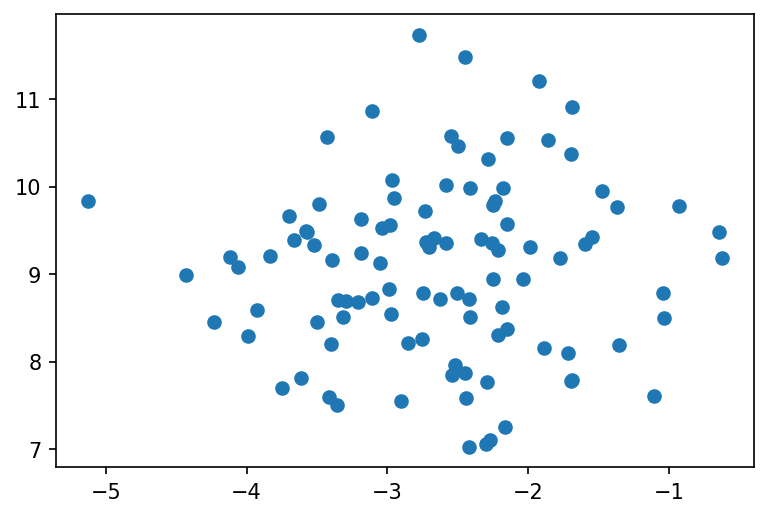

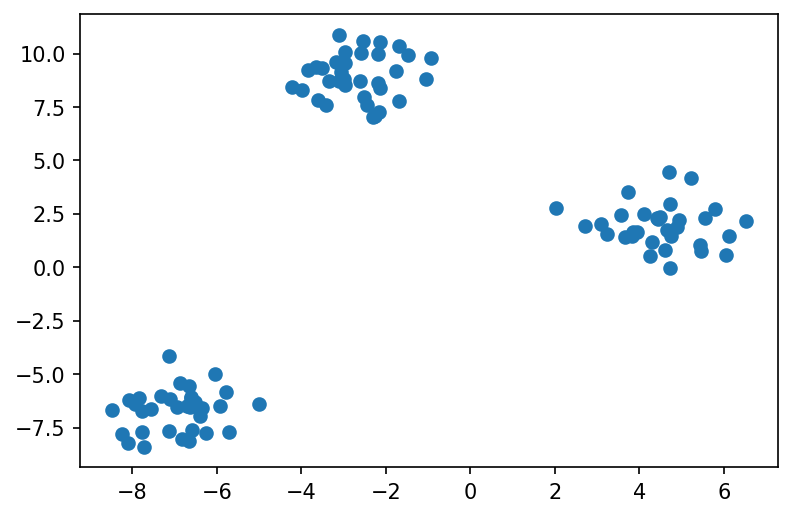

In [3]:
graph_data(coords)
graph_data(coords_cluster)

## Running Dissimilarity Algorithms

### Brute Strength - MaxMin

In [8]:
# MaxMin method
from selector.methods.partition import *
from selector.methods.dissimilarity import *

# diverse subset selection from randomly generated data points
selector = MaxMin()
selected_ids1 = selector.select(arr=arr_dist, size=12)

# diverse subset selection from data points with obvious patterns (different clusters)
selector = MaxMin()
selected_ids2 = selector.select(arr=arr_dist_cluster, labels=class_labels_cluster, size=12)

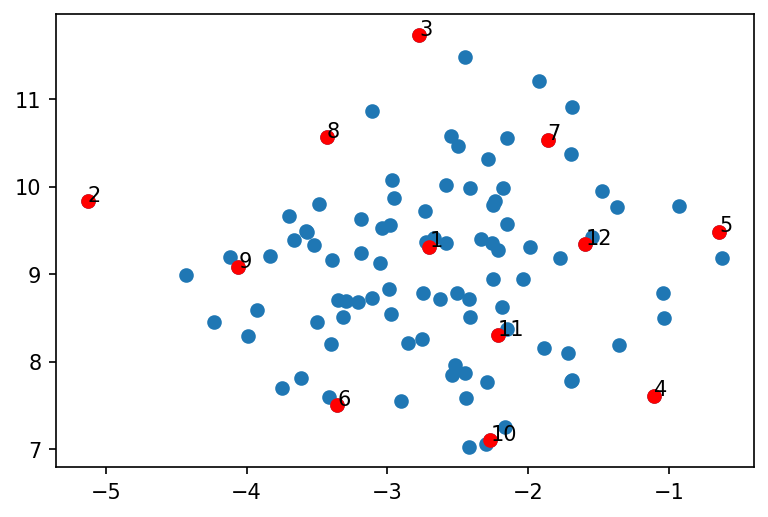

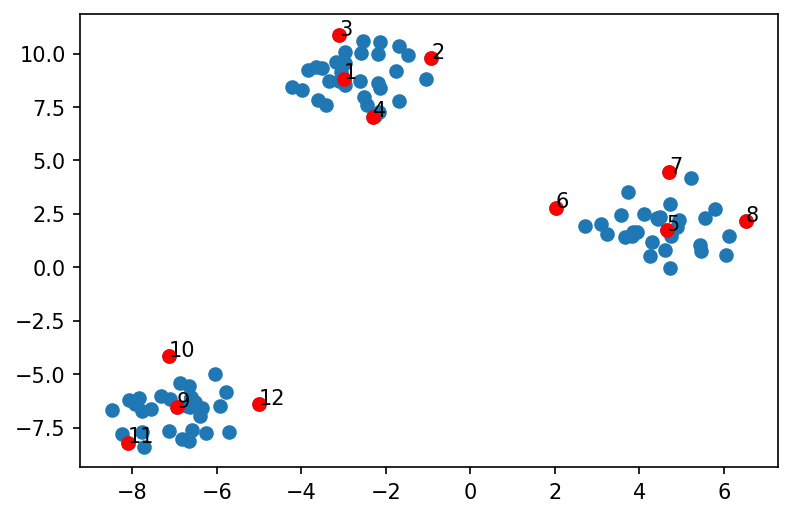

In [9]:
graph_data(coords,selected_ids1)
graph_data(coords_cluster,selected_ids2)

### Adapted Optimizable K-Dissimilarity Selection (OptiSim)

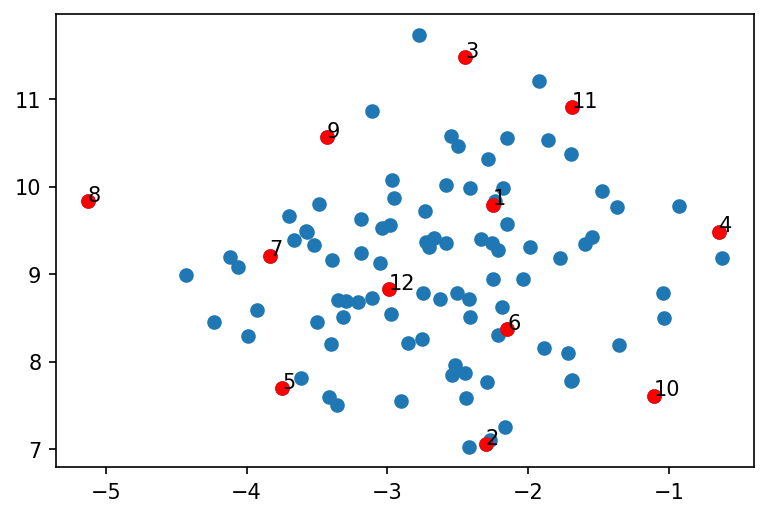

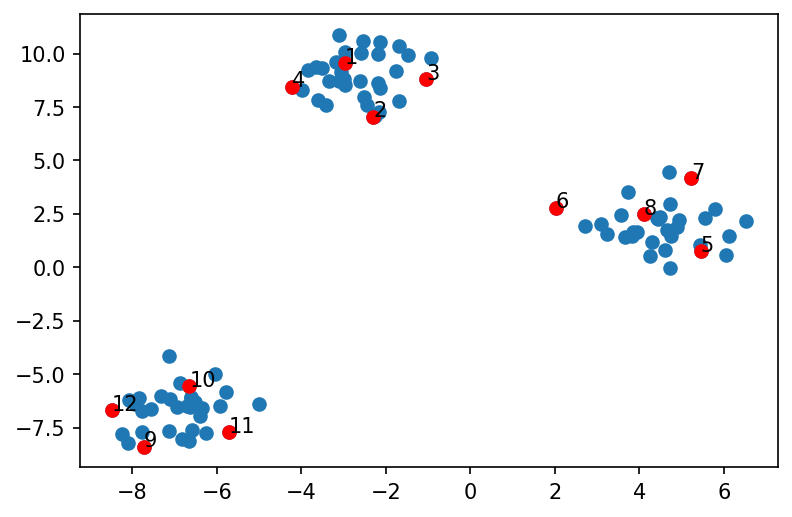

In [12]:
# diverse subset selection from randomly generated data points
selected_id3 = OptiSim().select(coords, 12)
# diverse subset selection from data points with obvious patterns (different clusters)
selected_id4 = OptiSim().select(coords_cluster, size=12, labels=class_labels_cluster)

graph_data(coords,selected_id3)
graph_data(coords_cluster,selected_id4)

### Directed Sphere Exclusion

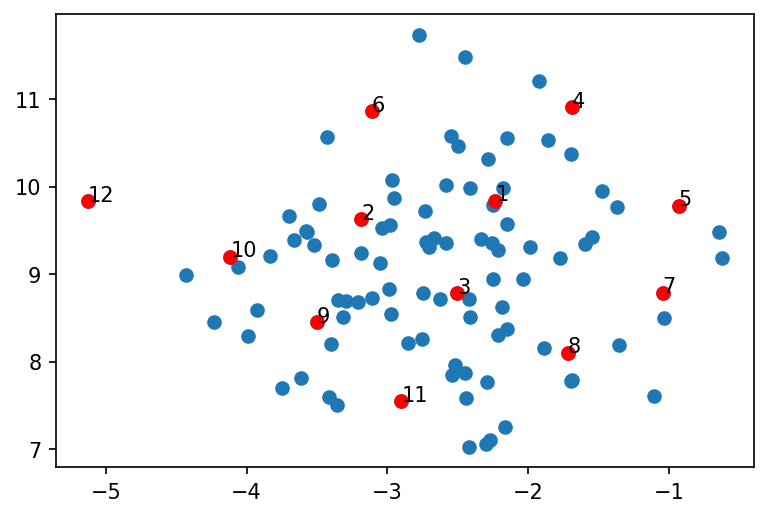

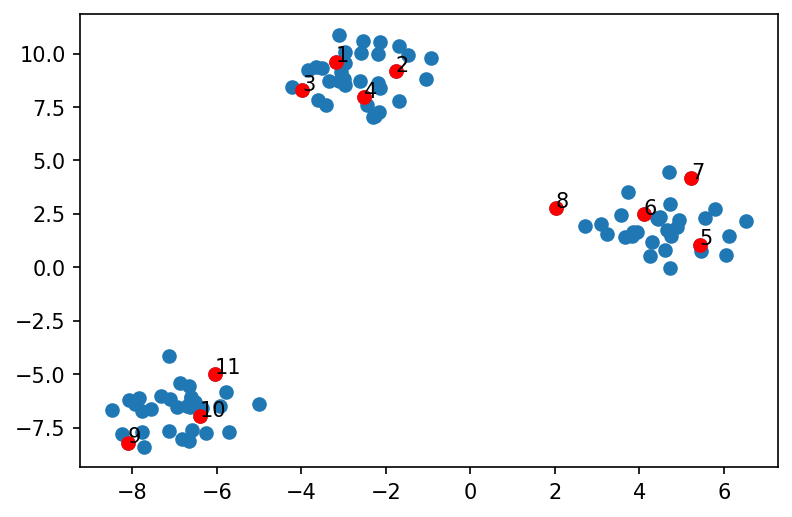

In [13]:
# diverse subset selection from randomly generated data points
selected_id5 = DirectedSphereExclusion().select(coords, 12)
# diverse subset selection from data points with obvious patterns (different clusters)
selected_id6 = DirectedSphereExclusion().select(coords_cluster, size=12, labels=class_labels_cluster)

graph_data(coords,selected_id5)
graph_data(coords_cluster,selected_id6)

### Grid Partitioning Method

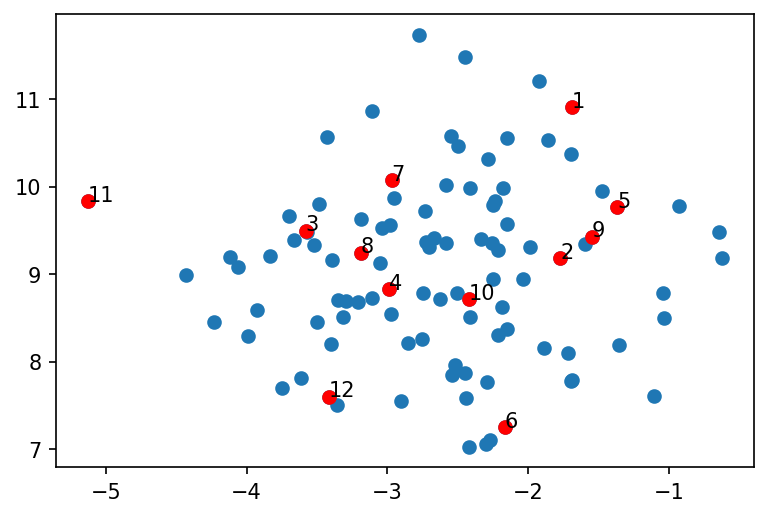

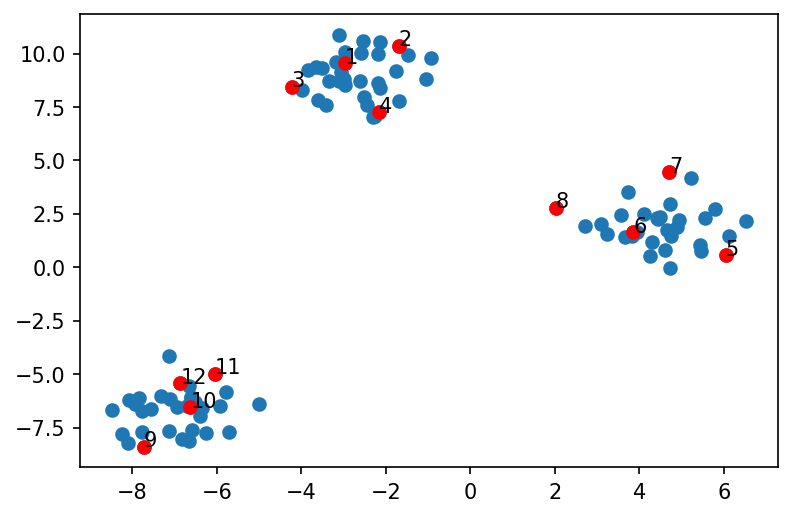

In [15]:
# diverse subset selection from randomly generated data points
selected_id7 = GridPartitioning(2, "equisized_independent").select(coords, 12)
# diverse subset selection from data points with obvious patterns (different clusters)
selected_id8 = GridPartitioning(2, "equisized_independent").select(coords_cluster, 
                                                                   size=12, 
                                                                   labels=class_labels_cluster)

graph_data(coords,selected_id7)
graph_data(coords_cluster,selected_id8)
# 20, 5, 3, "equisized_independent"

## MinMax selection with clusters, but without assuming there are clusters

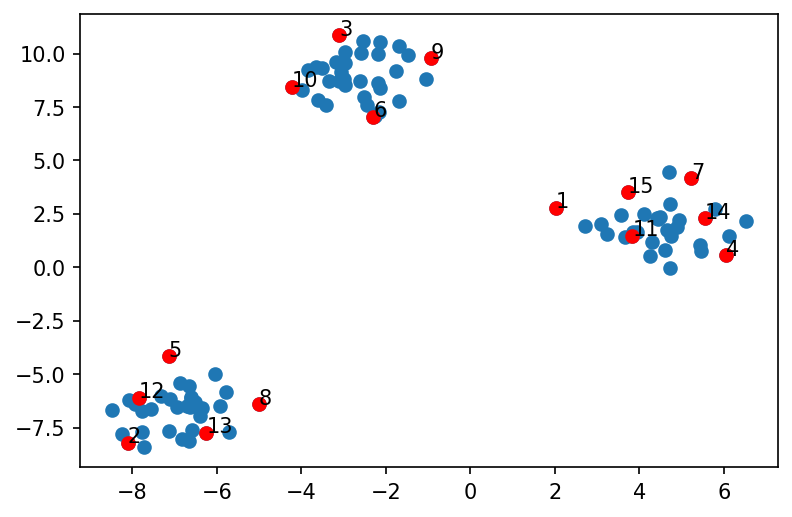

In [16]:
selector = MaxMin()
selected_ids = selector.select(arr=arr_dist_cluster, size=15)
graph_data(coords_cluster, selected_ids)

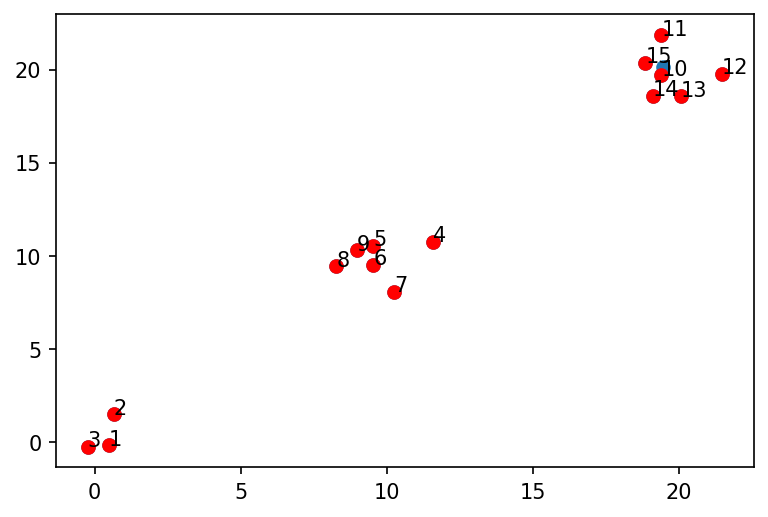

[0, 1, 2, 3, 4, 5, 6, 7, 8, 14, 15, 10, 11, 9, 13]

In [12]:
import numpy as np
from sklearn.metrics import pairwise_distances
np.random.seed(42)
cluster_one = np.random.normal(0, 1, (3,2))
cluster_two = np.random.normal(10, 1, (6,2))
cluster_three = np.random.normal(20, 1, (7,2))
labels_mocked = np.hstack([[0 for i in range(3)],
                          [1 for i in range(6)],
                          [2 for i in range(7)]])

mocked_cluster_coords = np.vstack([cluster_one, cluster_two, cluster_three])
selector = MaxMin(lambda x: pairwise_distances(x, metric='euclidean'))
selected_mocked = selector.select(mocked_cluster_coords, size=15, labels=labels_mocked)

graph_data(mocked_cluster_coords, selected_mocked)

selected_mocked

### Brute Strength - maxsum

In [6]:
selector = DissimilaritySelection(num_selected=12,
                                  arr_dist=arr_dist,
                                  random_seed=42,
                                  method="maxsum")
selector.starting_idx = 0
selected_ids2 = selector.select()

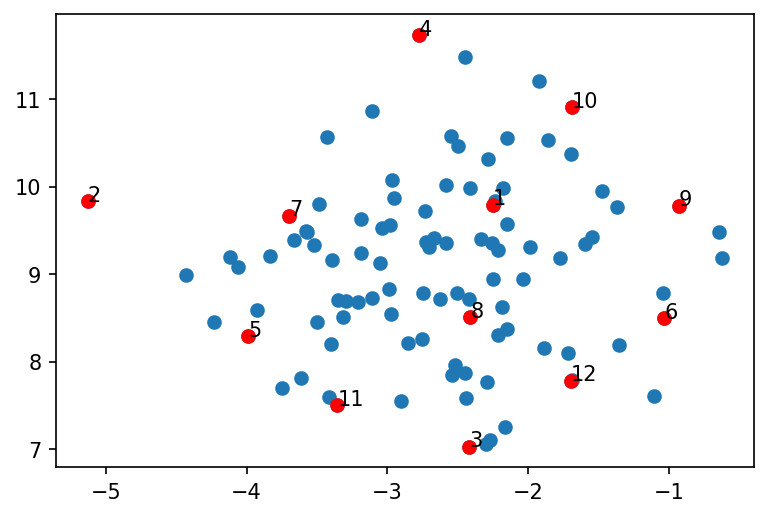

In [7]:
graph_data(selected_ids2)

### Grid Partitioning - Equisized Independent

In [8]:
selector = DissimilaritySelection(features=coords,
                                  num_selected=12,
                                  arr_dist=arr_dist,
                                  grid_method="grid_partioning",
                                  random_seed=42)
selector.starting_idx = 0
selected_ids3 = selector.select()

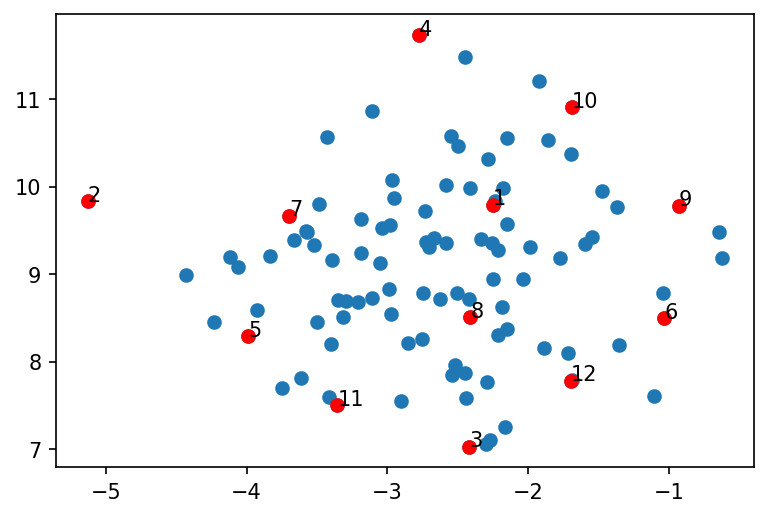

In [9]:
graph_data(selected_ids3)

### Grid Partitioning - Equisized Dependent

In [10]:
selector = DissimilaritySelection(num_selected=12,
                                  features = coords,
                                  random_seed=42,
                                  dissim_func="grid_partitioning",
                                  grid_method="equisized_dependent")
selector.starting_idx = 0
selected_ids4 = selector.select()

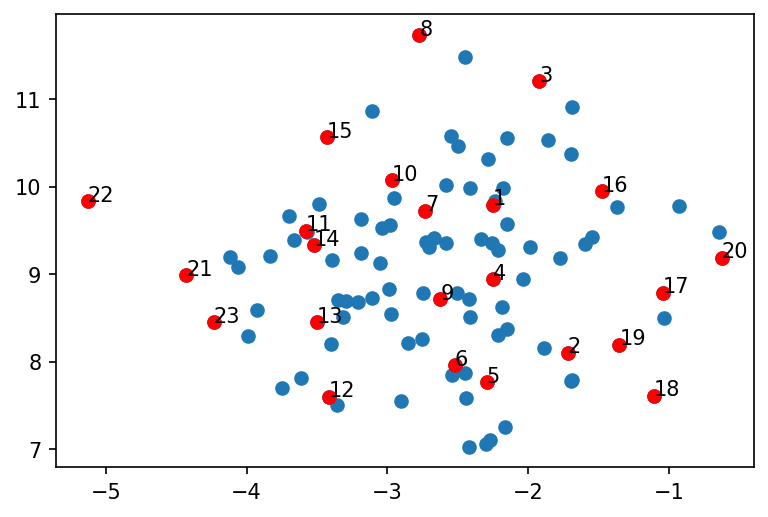

In [11]:
graph_data(selected_ids4)

### Directed Sphere Exclusion

In [12]:
selector = DissimilaritySelection(num_selected=12,
                                  features=coords,
                                  dissim_func="sphere_exclusion",
                                  random_seed=42)
selector.starting_idx = 0
selected_ids5 = selector.select()

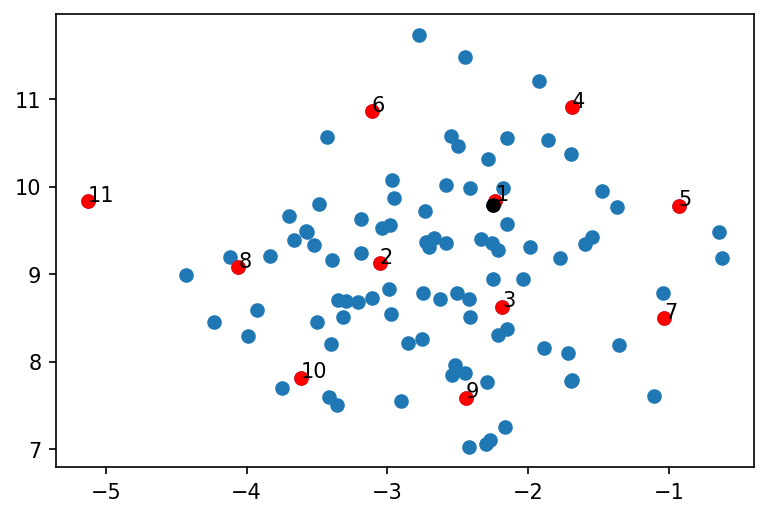

In [13]:
graph_data(selected_ids5, True)

### Optisim

In [14]:
selector = DissimilaritySelection(num_selected=12,
                                  features=coords,
                                  dissim_func="optisim",
                                  random_seed=42)
selector.starting_idx = 0
selected_ids6 = selector.select()

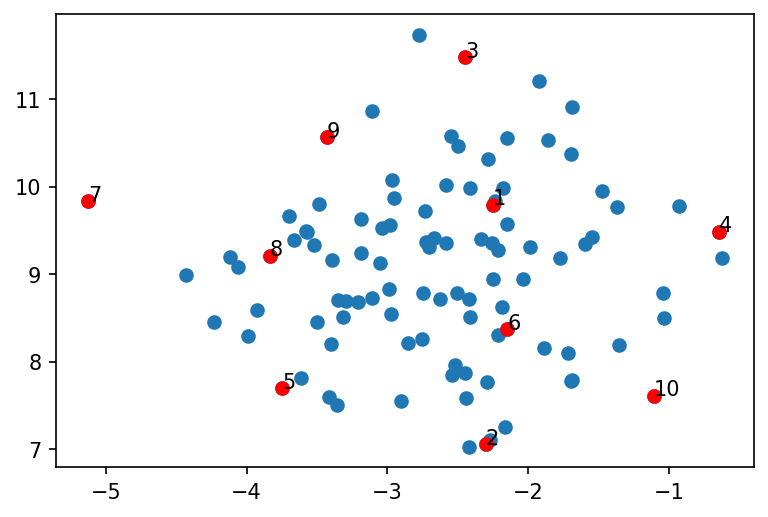

In [15]:
graph_data(selected_ids6)